# Generating a pseudo reference database

In [1]:
#loading libraries
import numpy as np
import scipy as sp
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import bokeh.plotting

# For interfacing with the file system
import glob
import subprocess
import os
import time

import importlib
import bilge_pype as bpy

# pipes bokeh output to the notebook
bokeh.io.output_notebook()
# enables some logging output
bpy.init_log(level='INFO')

Loading BokehJS ...

## Loading data into python
After running the basecaller on fast5 files, you will have a folder containing basecalled fastq reads. `bilge_pype.py` contains a few useful functions for reading and writing fastq and fasta files. As some of these files could be quite large, we use the `low_mem=True` option to save on RAM when running this notebook, but still allow us to fetch the sequence and quality strings.

In [2]:
fastq_folder = 'fastq'
files = glob.glob(fastq_folder+'/*.fastq')         # find list of fastq files to read
df_reads = bpy.load_ONT_fastq(files, low_mem=True) # reads fastq files and parses the header

pid[7875] 2020-05-18 16:22:35.679 INFO: Processing 0/271, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_0_0.fastq
pid[7875] 2020-05-18 16:22:35.680 INFO: elapse = 0.20s
pid[7875] 2020-05-18 16:22:40.053 INFO: Processing 20/271, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_19_0.fastq
pid[7875] 2020-05-18 16:22:40.053 INFO: elapse = 4.57s
pid[7875] 2020-05-18 16:22:44.365 INFO: Processing 40/271, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_40_0.fastq
pid[7875] 2020-05-18 16:22:44.366 INFO: elapse = 8.89s
pid[7875] 2020-05-18 16:22:49.755 INFO: Processing 60/271, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_62_0.fastq
pid[7875] 2020-05-18 16:22:49.756 INFO: elapse = 14.28s
pid[7875] 2020-05-18 16:22:56.756 INFO: Processing 80/271, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_80_0.fastq
pid[7875] 2020-05-18 16:22:56.757 INFO: elapse = 21.28s
pid[7

In [3]:
df_reads.iloc[:5]

,id,seek1,rlen,seek2,filename,read,ch,start_time,length
0,f0664328-0f63-44c6-99f8-95d5e5dedc8e,147,1665,1815,fastq/fastq_runid_477fdb09921842662b221840eee0...,37,95,2019-02-06 02:36:48+00:00,1665
1,ac4d0cb4-b909-42c0-a0df-bd5d4f0f22ef,3629,327,3959,fastq/fastq_runid_477fdb09921842662b221840eee0...,42,311,2019-02-06 02:36:55+00:00,327
2,304abdae-e026-4fd5-a98d-0816cfa9114f,4435,425,4863,fastq/fastq_runid_477fdb09921842662b221840eee0...,16,125,2019-02-06 02:36:34+00:00,425
3,2b365105-b037-4140-aa22-1e2a8252feb1,5438,4442,9883,fastq/fastq_runid_477fdb09921842662b221840eee0...,100,491,2019-02-06 02:38:03+00:00,4442
4,bc88acc6-7312-48c2-8796-ab4964dd3d61,14475,3111,17589,fastq/fastq_runid_477fdb09921842662b221840eee0...,115,335,2019-02-06 02:38:28+00:00,3111


`id` is a unique identifier string for each fastq read.

`ch` is the channel where the read originated from.

`start_time` is the acquisition time of read.

`length` is the length of the sequence.

Apply `add_seq()` to `df_reads` to get the sequence and quality information.

In [4]:
bpy.add_seq(df_reads.iloc[:5])

,id,read,ch,start_time,length,sequence,quality
0,f0664328-0f63-44c6-99f8-95d5e5dedc8e,37,95,2019-02-06 02:36:48+00:00,1665,ATCGGTAATATGCTTCGTTCGGTTACGTATTGCTGGCGTCTTAGCC...,"%2)+'''$%#%%(-.,-//+))1&&')*(--',(0('(0,/-*),,..."
1,ac4d0cb4-b909-42c0-a0df-bd5d4f0f22ef,42,311,2019-02-06 02:36:55+00:00,327,ATCCATTGTACTTCGTTCGGTTACGTATTGCTGGCGTCTGCTTGAT...,"&-*(%(*(*)*/-(*,-0))-*)*.5-1.++'-'('5331++('+/..."
2,304abdae-e026-4fd5-a98d-0816cfa9114f,16,125,2019-02-06 02:36:34+00:00,425,ATCGGTAGCCATGATTCGGTTACACGTATTGCTGGCGTCTGCTTAT...,"'(,),(&%*%#$($)+(%(.(&'&+(*((/-/1.5/./240-,0,-..."
3,2b365105-b037-4140-aa22-1e2a8252feb1,100,491,2019-02-06 02:38:03+00:00,4442,ATCAATTGGTAGCTGGGTTCAGTTACGTATTGCTGGCGTCTGCTTA...,"(-+)&)'&$$%#$'%%(05($&1')*02115///3653321*(,))..."
4,bc88acc6-7312-48c2-8796-ab4964dd3d61,115,335,2019-02-06 02:38:28+00:00,3111,ATCAGTGTGCTTGGATTTCAGTTACGTATTGCTGACGTCTCAAGCT...,"(*+(&*%)'&+&+'(/51++-)4*++31/5)($$#$$%%&%%&'&,..."


## Searching for reference sequences
Consensus building in `ashure.py` works by using a reference sequence to search for repeated sequences of interest in PCR products generated by rolling circle amplification. These repeats are later aligned to generate a more error free consensus. In the absence of a reference database, we would need a best guess at what we are sequencing. This is our pseudo reference database, which can be generated with primer information. We just need to know what sequences are flanking our mystery gene.

Searching every read for forward and reverse primer pairs is time intensive and unnecessary. PCR amplifies the original templates, making the reference over represented. We can filter out large repetitive fragments and just examine a subset that are likely to contain our reference sequences.

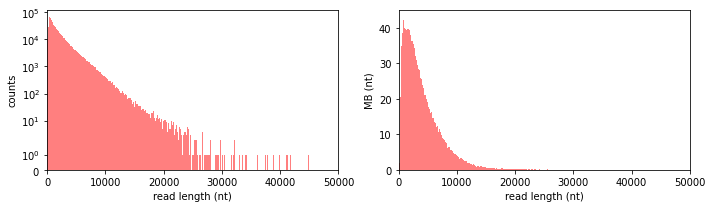

In [5]:
def plot_length_dist(ax, df, color = 'red', alpha = 0.5, label = '', by_counts = True):
    if by_counts:
        plt.hist(df['length'], bins = np.arange(0,50e3,100),
                 alpha = alpha, color = color, label = label)
        plt.ylabel('counts')
        plt.yscale('symlog')
    else:
        plt.hist(df['length'], bins = np.arange(0,50e3,100),
                 weights = df['length']/1e6, alpha = alpha, color = color, label = label)
        plt.ylabel('MB (nt)')
    plt.xlabel('read length (nt)')
    plt.xlim([0,50e3])

# print the distribution of read lengths
plt.figure(1, figsize=(10,3))

plt.subplot(1,2,1)
plot_length_dist(plt.gca(), df_reads, color='red')
plt.subplot(1,2,2)
plot_length_dist(plt.gca(), df_reads, color='red', by_counts=False)
plt.tight_layout()
plt.show()

The cytochrome oxidase subunit 1 (CO1) gene is about 700bp. Size filtering is used to filter out concatemers. We want to focus on non-repeated reads because there is a chance some reads are so corrupted that the primer sequence could not be found in the correct location. You could end up with concatemers instead of a single full length CO1.

To illustrate this, lets run `ashure.py` with length filtering from 500-1200bp and 500-3000.

In [6]:
cmd = './ashure.py prfg -fq fastq/*.fastq -fs 500-1200 -p primers.csv -o pseudo_ref.csv.gz --low_mem -r'
subprocess.run(cmd, shell=True) # submit the command to shell
cmd = './ashure.py prfg -fq fastq/*.fastq -fs 500-3000 -p primers.csv -o pseudo_ref_bad.csv.gz --low_mem -r'
subprocess.run(cmd, shell=True) # submit the command to shell

CompletedProcess(args='./ashure.py prfg -fq fastq/*.fastq -fs 500-3000 -p primers.csv -o pseudo_ref_bad.csv.gz --low_mem -r', returncode=0)

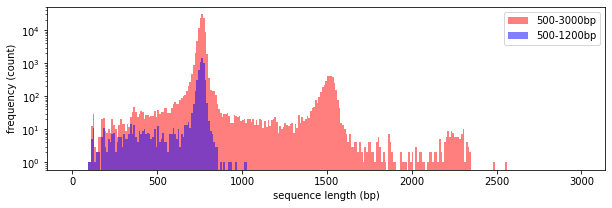

In [7]:
# load the pseudo reference sequences
df_prf1 = pd.read_csv('pseudo_ref.csv.gz')
df_prf2 = pd.read_csv('pseudo_ref_bad.csv.gz')
# add length information
df_prf1['length'] = [len(i) for i in df_prf1['sequence']]
df_prf2['length'] = [len(i) for i in df_prf2['sequence']]
# plot the length distribution
plt.figure(1, figsize=(10,3))
plt.hist(df_prf2['length'], bins=np.arange(0,3000,10), color='red', alpha=0.5, label='500-3000bp')
plt.hist(df_prf1['length'], bins=np.arange(0,3000,10), color='blue', alpha=0.5, label='500-1200bp')
plt.legend()
plt.xlabel('sequence length (bp)')
plt.ylabel('frequency (count)')
plt.yscale('log')
plt.show()

With larger bp size windows, concatemers will show up as peaks at around 1500bp and 2400bp. These concatemers are sometimes undesirable because they interfer with proper dereplication of an RCA read. In special cases, concatemers could be desirable because the gene of interest has many repetitive domains such as ankyrin proteins. We leave these decisions up to the user as you are the expert on the gene you are sequencing.

Filtering and concatenation of reads by size is fairly straight forward. An example is provided below.
```python
x = df_prf2[(df_prf2['length'] > 700) & (df_prf2['length'] < 1000)]    # get sequences between 700-1000bp
y = df_prf2[(df_prf2['length'] > 1200) & (df_prf2['length'] < 1600)]   # get sequences between 1200-1600bp
df = pd.concat([x,y]) # concatenate the dateframes
df.to_csv('example.csv.gz', compression='infer', index=False)    # write the data to csv
```

## Clustering and compressing the pseudo reference
Compacting and dereplicating the pseudo reference can significantly speed up run time without hurting accuracy and sensitivity. This is possible because the pseudo reference contains many redundant sequences. Remember that exact matches are not required. The pseudo reference is meant to be a fuzzy representation of the overall dataset such that genes of interest can quickly be found.

The code snippet below shows how to align the pseudo reference against the true reference database for mock50 samples and reveal the redundancy of information in the pseudo reference.

In [8]:
# load true reference and pseudo reference databases
df_ref = bpy.read_fasta('ref_db.fa')
df_prf = pd.read_csv('pseudo_ref.csv.gz')
# align pseudo reference against the mock50
df_acc = bpy.run_minimap2(df_prf, df_ref, config='-k8 -w1', cleanup=True)
df_acc = bpy.get_best(df_acc,['query_id'], metric='AS', stat='idxmax')

pid[7875] 2020-05-18 16:28:45.354 INFO: Making directory ./minimap2/


`run_minimap2()` is a wrapper function to minimap2 in `bilge_pype.py`. To get more help, type `help(bpy.run_minimap2)` in python shell.

`get_best()` is a helpful function to filter to the best alignment

Alignment of fasta or csv files against other fasta or csv file can also be invoked using `get_accuracy.py`. This script depends on `bilge_pype.py`. Below is an example usage:

```bash
./get_accuracy.py -h     # get help
./get_accuracy.py -i pseudo_ref.csv.gz -o acc.csv.gz   # input pseudo_ref.csv.gz and output to acc.csv.gz
```

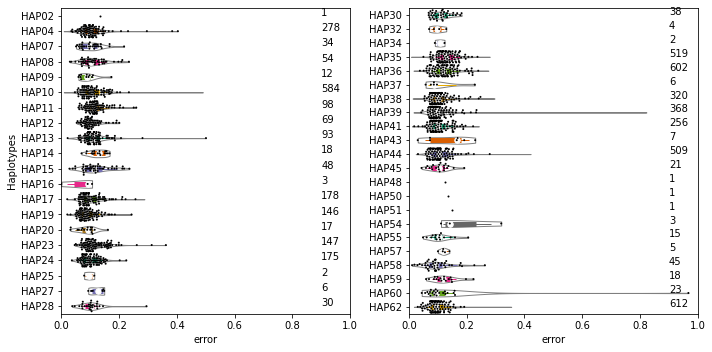

In [9]:
def plot_acc(df_acc, haps):
    data = df_acc[df_acc['database_id'].isin(haps)]
    data = data.sort_values(by = ['database_id'])
    data['error'] = 1-data['similarity']

    # subsample to data to make swarmplot work
    df_sub = bpy.stats_subsample(data, col='database_id', N=100)
    # split into subplots swarm plot don't look crowded
    slist = np.array_split(haps,2)
    for i in range(0, len(slist)):
        plt.subplot(1,2,i+1)
        d = data[data['database_id'].isin(slist[i])]
        cmap = plt.cm.get_cmap('Dark2').colors
        bpy.mpl_box_whisker(plt.gca(), d[['database_id','error']],text_y=0.9, counts=True, cmap=cmap)
        bpy.mpl_violin(plt.gca(), d[['database_id','error']], face_color='white', edge_color='black')
        d = df_sub[df_sub['database_id'].isin(slist[i])]
        sns.swarmplot(x='error', y='database_id', data=d, alpha=1, color='Black', s=2)
        plt.ylabel('')
        if i == 0: plt.ylabel('Haplotypes')
        plt.xlim([0,1])
    plt.tight_layout()

# get the names of the mock50 haplotypes
haps = df_ref[['HAP' in i for i in df_ref['id']]]['id'].values
# make a violin/swarm plot
plt.figure(1, figsize=(10,5))
plot_acc(df_acc, haps)
plt.show()

The violin/swarm plot above shows that some haplotypes are represented by 1 sequence, while some are represented by several hundred sequences. Compute time is waste on aligning every fastq read to every closely related pseudo reference sequence.

The ideal pseudo reference database for this dataset is around 50 sequences or one sequence for each mock50 sample. The pseudo reference can be compacted by invoking the `clst` module in `ashure.py`. The `clst` module uses OPTICS density clustering to order, label, merge, and return the representative center sequences for each haplotype. OPTICS is an unsupervised clustering algorithm that uses density to flag potential sequence clusters and cluster centers.

In [10]:
cmd = './ashure.py clst -i pseudo_ref.csv.gz -o pseudo_clst.csv.gz -iter 10 -r'  # runs clustering for 10 iterations
subprocess.run(cmd, shell=True)

CompletedProcess(args='./ashure.py clst -i pseudo_ref.csv.gz -o pseudo_clst.csv.gz -iter 10 -r', returncode=0)

pid[7875] 2020-05-18 16:31:15.242 INFO: Making directory ./minimap2/


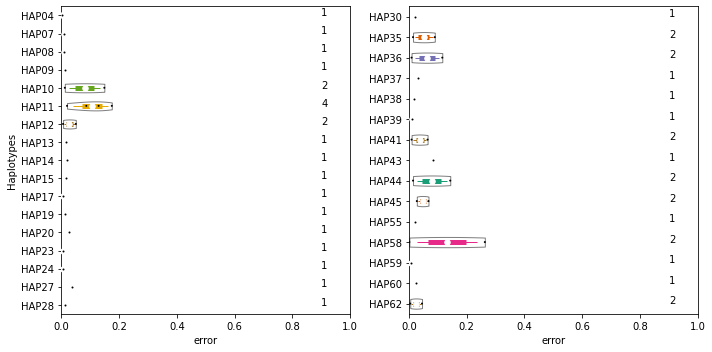

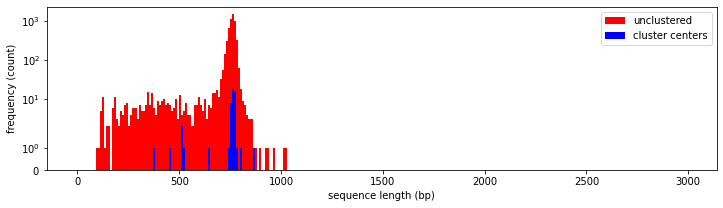

In [11]:
# load the data
df_prfc = pd.read_csv('pseudo_clst.csv.gz')
df_prf = pd.read_csv('pseudo_ref.csv.gz')
df_prf['length'] = [len(i) for i in df_prf['sequence']]
df_prfc['length'] = [len(i) for i in df_prfc['sequence']]
# align pseudo reference against the mock50
df_acc2 = bpy.run_minimap2(df_prfc, df_ref, config='-k8 -w1', cleanup=True)
df_acc2 = bpy.get_best(df_acc2,['query_id'], metric='AS', stat='idxmax')
plt.figure(1, figsize=(10,5))
plot_acc(df_acc2, haps)

plt.figure(2, figsize=(12,3))
plt.hist(df_prf['length'], bins=np.arange(0,3000,10), color='red', label='unclustered')
plt.hist(df_prfc['length'], bins=np.arange(0,3000,10), color='blue', label='cluster centers')
plt.legend()
plt.xlabel('sequence length (bp)')
plt.ylabel('frequency (count)')
plt.yscale('symlog')
plt.show()

In [12]:
print('clst module produced ',len(df_prfc),' cluster centers')
print('original pseudo reference size = ',len(df_prf))
n1 = len(np.unique(df_acc[df_acc['database_id'].isin(haps)]['database_id']))
n2 = len(np.unique(df_acc2[df_acc2['database_id'].isin(haps)]['database_id']))
print('haplotypes before: ', n1)
print('haplotypes after: ', n2)

clst module produced  51  cluster centers
original pseudo reference size =  5601
haplotypes before:  42
haplotypes after:  32


Clustering removed many of the redundant sequences. Although some rare haplotypes may have been lost, we retain the majority of the interesting sequences which could still be in our sample.

For some sequences, the accuracy of the pseudo reference entry improves because merging via multi-alignment successfully canceled out sequencing errors. For other sequences, the accuracy seems to have decreased because wrong sequences were merged together.

More on this will be elaborated in the next section and in [clustering.ipynb](clustering.ipynb)

To run the remainder of `ashure.py` with this compressed pseudo reference database, an example is shown below:

```bash
./ashure.py -h                  # get help
./ashure.py run -fq fastq/* -p primers.csv -db pseudo_clst.csv.gz -o1 cons.csv.gz --low_mem  # run the whole pipeline
```

### Detection of rare haplotypes
If detection of rare haplotypes is a priority, do not worry. The pseudo reference database does not need to be perfect. The sequences only need to approximately match your gene of interest. If the rare gene is wholly missed in the first run, `ashure.py` can be rerun on reads which did not strongly map to anything.

More on how to filter and rerun `ashure.py` to find rare haplotypes will be covered in [rare_haplotypes.ipynb](rare_haplotypes.ipynb)

## Visualizing the pseudo reference clusters

The similarity relationships between sequences can be visualized via a dendrogram, pairwise matrix, or tsne plot. In this section, we show how functions in `bilge_pype.py` can help you generate pairwise distance data, plot a dendrogram, and make tsne plots to visualize your sequence data.

### Getting pairwise distance information
In the code snippet below, pseudo reference sequences, cluster center sequences of the pseudo reference, and the mock50 reference sequences are loaded and concatenated. Pairwise alignments are computed via `run_minimap2()` and saved to a csv file called `pseudo_pw.csv.gz`.

In [13]:
def compute_pw(df):
    # note that -D in config remove entries for diagonal alignments. You will need to add this back for similarity measures
    df_pw = bpy.run_minimap2(df, df, config='-k15 -w10 -p 0.9 -D --dual=no', cleanup=True)
    return bpy.get_best(df_pw,['query_id','database_id'],metric='AS', stat='idxmax')  # get the best alignment

# load data and concatenate dataframes
df_prf = pd.read_csv('pseudo_ref.csv.gz')
df_cl = pd.read_csv('pseudo_clst.csv.gz')
df_ref = bpy.read_fasta('ref_db.fa')
df = pd.concat([df_prf, df_cl, df_ref])
df_pw = compute_pw(df[['id','sequence']])
df_pw.to_csv('pseudo_pw.csv.gz', index=False, compression='infer') # save the data

pid[7875] 2020-05-18 16:31:17.347 INFO: Making directory ./minimap2/


### Plotting a dendrogram
The code snippet below shows how to compute and plot a dendogram. Dendrograms show the relationship between pairs of sequences or subclusters. The example below, [complete linkage](https://en.wikipedia.org/wiki/Complete-linkage_clustering) clustering, tries to group together pairs of related sequences or subclusters while minimizing the maximum distance within a cluster.

### Plotting the TSNE representation of the distance relationships
Dendrograms are not the ideal way to view evolutionary relationships. Complicated relationships such as evenly spaced points on a sphere are not captured by dendrograms. Neighborhood embeddings such as TSNE are better at preserving high dimensional relationships. TSNE projects high dimensional relations onto low dimensional space and tries to minimize the divergence in neighborhood structure between the low dimension and high dimension representations of the data.

The code snippet below shows how to apply TSNE to the pseudo reference and obtain a 2D representation of the relationships between sequences. HDBSCAN is used to flag clusters in 2D space. Data is returned as a pandas dataframe and saved to `pseudo_tnse.csv.gz`.

In [14]:
def get_cluster(dist, metric='precomputed'):
    # runs tsne on distance matrix
    tsne = bpy.run_TSNE(dist, metric=metric)
    # run hdbscan on tsne output
    hdb = bpy.cluster_HDBSCAN(tsne, metric='euclidean', min_samples=20, min_cluster_size=10)
    hdb = hdb.rename(columns={'cluster_id':'hdbscan_id','ordering':'hdbscan_order'})
    return tsne.merge(hdb, on='id', how='left')

def get_dist_matrix(df):
    # extract the pairwise distance matrix and use match_score as the metric
    # match score is the tot_matching_bp/seq_len
    m = bpy.get_feature_vector(df[['query_id','database_id','similarity']], symmetric=True)
    # make this matrix symmetric
    m = bpy.get_symmetric_matrix(m, sym_larger=False)
    # invert similarity to distance
    for i in range(0,len(m)):
        m.iloc[:,i] = 1-m.iloc[:,i]
        m.iat[i,i] = 0 # set diagonal values to zero
    return m

# load pairwise data
df = pd.read_csv('pseudo_pw.csv.gz')
# get the distance matrix
m = get_dist_matrix(df)
# perform tsne, hdscan, and optics on the data
tsne = get_cluster(m, metric='precomputed')
tsne.to_csv('pseudo_tsne.csv.gz', compression='infer', index=False)

pid[7875] 2020-05-18 16:31:25.323 INFO: running sklearn tsne with n_comp = 2
pid[7875] 2020-05-18 16:33:20.486 INFO: Running HDBSCAN
pid[7875] 2020-05-18 16:33:20.613 INFO: getting and ordering the results
pid[7875] 2020-05-18 16:33:20.633 INFO: number of clusters = 38
pid[7875] 2020-05-18 16:33:20.633 INFO: unclustered = 2599


The code snippet below aligns the pseudo reference against the pseudo cluster centers and true reference. This information lets us colorize the scatter plots and interpret how well OPTICS performed.

In [15]:
# load sequence data
prf = pd.read_csv('pseudo_ref.csv.gz')
prf['source'] = 'samples'
ref = bpy.read_fasta('ref_db.fa')
ref = ref[[('HAP' in i) for i in ref['id']]]
ref['source'] = 'reference'
ref['ref_id'] = ref['id']
clst = pd.read_csv('pseudo_clst.csv.gz')
clst['source'] = 'clst'
clst['clst_id'] = clst['id']
# align reference database to pseudo reference and pseudo reference clusters to pseudo reference
A = bpy.run_minimap2(prf, ref, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
A = bpy.get_best(A,['id'],metric='match_score',stat='idxmax')
B = bpy.run_minimap2(prf, clst, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
B = bpy.get_best(B,['id'],metric='match_score',stat='idxmax')
A = A.rename(columns={'database_id':'ref_id','match_score':'ref_match'})
B = B.rename(columns={'database_id':'clst_id','match_score':'clst_match'})
# merge alignment data
prf = prf.merge(A[['id','ref_id','ref_match']], on='id', how='left')
prf = prf.merge(B[['id','clst_id','clst_match']], on='id', how='left')
df = pd.concat([prf,ref,clst])
# merge into tsne
tsne = pd.read_csv('pseudo_tsne.csv.gz')
tsne = tsne.merge(df, on='id', how='left')
# add colors to ref_id
col = 'ref_id'
rid = np.unique(tsne[col].dropna())
cmap = bokeh.palettes.Category20b_20
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'ref_id_color'])
tsne = tsne.merge(colors,on='ref_id',how='left')
# add colors to clst_id
col = 'clst_id'
rid = np.unique(tsne[col].dropna())
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'clst_id_color'])
tsne = tsne.merge(colors,on='clst_id',how='left')

pid[7875] 2020-05-18 16:33:20.847 INFO: Making directory ./minimap2/
pid[7875] 2020-05-18 16:33:23.635 INFO: Making directory ./minimap2/


In [ ]:
TOOLTIPS = [('id','@id'),
            ('ref_id', '@ref_id'),
            ('ref_match','@ref_match'),
            ('clst_id','@clst_id'),
            ('clst_match','@clst_match'),
            ('hdbscan_id','@hdbscan_id'),
            ('optics_id','@optics_id')]
p = bokeh.plotting.figure(plot_width=600, plot_height=500, tooltips=TOOLTIPS)

# plot samples colored by ref_match
d = tsne[tsne['source']=='samples']
mapper = bokeh.transform.linear_cmap(field_name='ref_match', palette=bokeh.palettes.Spectral11, low=0.8, high=1)
color_bar = bokeh.models.ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))
#p.circle('f_0', 'f_1', color=mapper, size=5, source=d)
p.circle('f_0', 'f_1', color='clst_id_color', size=5, source=d)

# plot cluster centers
d = tsne[tsne['source']=='clst']
p.square('f_0', 'f_1', line_color='black', fill_color='red', size=6, source=d)
d = tsne[tsne['source']=='reference']
p.diamond('f_0', 'f_1', line_color='black', fill_color='blue', size=10, source=d)

p.add_layout(color_bar, 'right')
bokeh.plotting.show(p)

HAP61 is on edge of HAP38

HAP05, HAP54 is on edge of HAP39

HAP31 on edge of HAP28

HAP18 is on edge of HAP62

In [22]:
clst[clst['id']=='cluster45'].values

array([['cluster45',
        'CGTGGTATTACTTGGTAGTTACGCGGGTGAACGGTCAACAAATCATAAAGACATCGGTACTCTATATTTCATTTTTTGGTGCTTGGGCATTTATGGTAGGGACCTCATTAAGACTTTTAATTCGAGCCGAGTTGGGTACAGGTTCGTGGTGGGGACGACAAATTTATAACGTAATCGTAACTGCTCATGCCTTTATTATGATTTTTTTTATAAATACCTATTTAATTGGGGTTAGATTTAGTTGCAGGATAAACAGCCACTTTGATCTATTTTCAACCCGGCTGGTGGTGGAGACCCTATTTTTACCAACACTTATTTTGATTTTTGGTCACCCTGAAGTTTACAGTAATCTCCATCATTGAGACACCCGAGCCA',
        True, 'clst', 'cluster45']], dtype=object)

In [23]:
clst[clst['id']=='cluster31'].values

array([['cluster31',
        'CGTGGTATTACTTGGTAGTTACGCGGGTGAACGGTCAACAAATCATAAAGACATTGGTACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACCTCATTAAGACTTTTAATTCGAGCCGAGTTGGGTAACCCGGGTTCATTAATTGGGGACGATCAAATTTATAACGTAATCGTAACTGCTCATGCCTTTATTATGATTTTTTTTTATAGTGATACCTATTATAATTGGGGTTTTGGAAATTGGTTAGTCCTCTGATGTTAGGTGCTCCAGATATAGCATTCCCTCGTATAAACAACATAAGTTTTTGGTTATTGCCTCCTTCTTTAACACTTCTCGTGTCTAGAAGAATTGTTGACGTAGGTGCTGGTACTGGTTGAACTGTTTATCCTCCTCTCGCCGCAAATATCGCCCACGGAGGGTCTTCGGTTGATTTCGCAATTTTTTCTTTACACTTGGCTGGTATTTCTTCGATTTTAGGTGCAGTTAATTTTATTACTACAGTTGTTAATATGCGTAGCCCTGGAATAACCCTAGACCGGATACCATTATTTGTTTGATCTGTAGTTATTACGGCTGTGTTACTGCTTTTATCGTTGCCAGTCTTAGCTGGTGCAATTACGATACTATTAACTGACCGAAATTTAAATACTTCATTTTTTGATCCTGCTGGGGGTGGGGATCCTATTTTATACCAGCATTTATTTTGATTTTTGGTCACCCTGAAGTTTACAGTAATCTCCATCATTGAGACACCTGAGCCA',
        False, 'clst', 'cluster31']], dtype=object)